In [1]:
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


rows,cols=(224,224)


#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (rows,cols))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = Variable(torch.from_numpy(img).to(device).float())
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

label=np.argmax(model(img).data.cpu().numpy())
print("label={}".format(label))


torch.Size([1, 3, 224, 224])
label=388


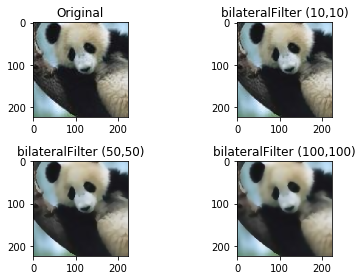

In [3]:
img2=cv2.bilateralFilter(orig.copy(),11,10,10)
img3=cv2.bilateralFilter(orig.copy(),11,50,50)
img4=cv2.bilateralFilter(orig.copy(),11,100,100)
 

plt.subplot(221)
plt.imshow(orig,cmap=plt.cm.gray) 
plt.title("Original")

plt.subplot(222)
plt.imshow(img2,cmap=plt.cm.gray) 
plt.title("bilateralFilter (10,10)")

plt.subplot(223)
plt.imshow(img3,cmap=plt.cm.gray) 
plt.title("bilateralFilter (50,50)")

plt.subplot(224)
plt.imshow(img4,cmap=plt.cm.gray) 
plt.title("bilateralFilter (100,100)")

plt.tight_layout()

In [4]:
def infer_img(img,t=0):
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
    
    
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    #print("label={}".format(label))
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    
    #print("{}={}".format(t,pro))
    return pro

In [5]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))

0.9270878
3.1756701e-06
0.9270878


rotate=0 pro[388]=0.927069902420044
rotate=10 pro[388]=0.9134399890899658
rotate=20 pro[388]=0.851268470287323
rotate=30 pro[388]=0.8163094520568848
rotate=40 pro[388]=0.8003881573677063
rotate=50 pro[388]=0.7744521498680115
rotate=60 pro[388]=0.7260379195213318
rotate=70 pro[388]=0.6810597777366638
rotate=80 pro[388]=0.664679765701294
rotate=90 pro[388]=0.6601906418800354
rotate=100 pro[388]=0.6592541933059692
rotate=110 pro[388]=0.6679579615592957
rotate=120 pro[388]=0.6740995645523071
rotate=130 pro[388]=0.675528883934021
rotate=140 pro[388]=0.6769252419471741
rotate=150 pro[388]=0.6716423034667969
rotate=160 pro[388]=0.6696864366531372
rotate=170 pro[388]=0.655799150466919
rotate=180 pro[388]=0.6418743133544922
rotate=190 pro[388]=0.6264687776565552
rotate=200 pro[388]=0.6066995859146118
rotate=210 pro[388]=0.5845211744308472
rotate=220 pro[388]=0.5655604600906372
rotate=230 pro[388]=0.547192394733429
rotate=240 pro[388]=0.5350071787834167
rotate=250 pro[388]=0.5190689563751221
rot

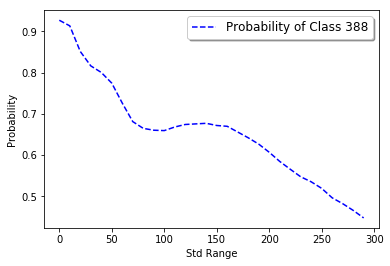

In [6]:
#验证原始图片对滤波器的鲁棒性
std_range = range(0,300,10)
original_pro = []

for i in std_range:
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    pro=infer_img(bilateralFilter_img.copy(),388)
    print("rotate={} pro[388]={}".format(i,pro))
    original_pro += [pro]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(original_pro), 'b--', label='Probability of Class 388')


legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

In [7]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False
    
optimizer = torch.optim.Adam([img])
loss_func = torch.nn.CrossEntropyLoss()

epochs=100
e=0.007

target=288
target=Variable(torch.Tensor([float(target)]).to(device).long())

for epoch in range(epochs):
    
    # forward + backward
    #output = model(img)
    output = F.softmax(model(img),dim=1)

    loss = loss_func(output, target)
    label=np.argmax(output.data.cpu().numpy())
    pro=output.data.cpu().numpy()[0][label]
    
    print("epoch={} loss={} label={} pro={}".format(epoch,loss,label,pro))
    
    #如果定向攻击成功 并且概率大于阈值
    if (label == target) and ( pro > 0.80):
        print("")
        break
         
    #梯度清零
    optimizer.zero_grad()
    #反向传递 计算梯度   
    loss.backward()
    
    img.data=img.data-e*torch.sign(img.grad.data)


epoch=0 loss=6.909350872039795 label=388 pro=0.9270877838134766
epoch=1 loss=6.908728122711182 label=388 pro=0.13656507432460785
epoch=2 loss=6.907952785491943 label=387 pro=0.08568044751882553
epoch=3 loss=6.899841785430908 label=219 pro=0.05838492140173912
epoch=4 loss=6.81821346282959 label=293 pro=0.11074680835008621
epoch=5 loss=6.628979682922363 label=288 pro=0.2798868715763092
epoch=6 loss=6.544139385223389 label=288 pro=0.36470136046409607
epoch=7 loss=6.411447048187256 label=288 pro=0.4975048899650574
epoch=8 loss=6.155745506286621 label=288 pro=0.753385603427887
epoch=9 loss=6.044737339019775 label=288 pro=0.8645306825637817



In [8]:
#把对抗样本转换成正常图片
adv=img.data.cpu().numpy()[0]
print(adv.shape)

adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 255.0
adv = np.clip(adv, 0, 255).astype(np.uint8)

print(adv.shape)

(3, 224, 224)
(224, 224, 3)


rotate=0 pro[388]=0.927069902420044 pro[288]=3.175290885337745e-06
rotate=10 pro[388]=0.9134399890899658 pro[288]=2.0392842543515144e-06
rotate=20 pro[388]=0.851268470287323 pro[288]=1.540732000648859e-06
rotate=30 pro[388]=0.8163094520568848 pro[288]=9.021194955494138e-07
rotate=40 pro[388]=0.8003881573677063 pro[288]=7.407922453239735e-07
rotate=50 pro[388]=0.7744521498680115 pro[288]=7.558347192571091e-07
rotate=60 pro[388]=0.7260379195213318 pro[288]=8.909933058021124e-07
rotate=70 pro[388]=0.6810597777366638 pro[288]=1.0407843547000084e-06
rotate=80 pro[388]=0.664679765701294 pro[288]=1.13656301437004e-06
rotate=90 pro[388]=0.6601906418800354 pro[288]=1.2568842748805764e-06
rotate=100 pro[388]=0.6592541933059692 pro[288]=1.4871673101879423e-06
rotate=110 pro[388]=0.6679579615592957 pro[288]=1.8200437352788867e-06
rotate=120 pro[388]=0.6740995645523071 pro[288]=2.2889551019034116e-06
rotate=130 pro[388]=0.675528883934021 pro[288]=3.0377477742149495e-06
rotate=140 pro[388]=0.6769252

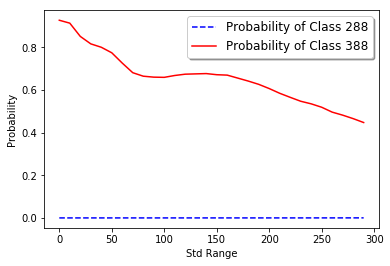

In [10]:
#验证滤波器 对抗样本的影响
std_range = range(0,300,10)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    
    pro_388=infer_img(bilateralFilter_img.copy(),388)
    pro_288=infer_img(bilateralFilter_img.copy(),288)
    print("rotate={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

rotate=0 adv_pro[388]=3.844920502160676e-05 original_pro[388]=0.927069902420044
rotate=10 adv_pro[388]=0.03123411163687706 original_pro[388]=0.9134399890899658
rotate=20 adv_pro[388]=0.15230613946914673 original_pro[388]=0.851268470287323
rotate=30 adv_pro[388]=0.28192222118377686 original_pro[388]=0.8163094520568848
rotate=40 adv_pro[388]=0.4362794756889343 original_pro[388]=0.8003881573677063
rotate=50 adv_pro[388]=0.5113372802734375 original_pro[388]=0.7744521498680115
rotate=60 adv_pro[388]=0.4995396137237549 original_pro[388]=0.7260379195213318
rotate=70 adv_pro[388]=0.4877852499485016 original_pro[388]=0.6810597777366638
rotate=80 adv_pro[388]=0.48460933566093445 original_pro[388]=0.664679765701294
rotate=90 adv_pro[388]=0.5038074254989624 original_pro[388]=0.6601906418800354
rotate=100 adv_pro[388]=0.5137888789176941 original_pro[388]=0.6592541933059692
rotate=110 adv_pro[388]=0.5232675075531006 original_pro[388]=0.6679579615592957
rotate=120 adv_pro[388]=0.5420792698860168 orig

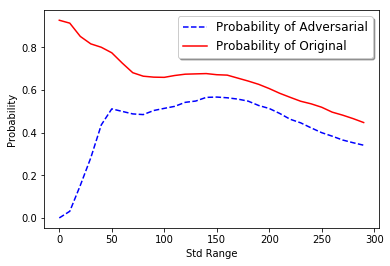

In [13]:
#综合分析滤波对 对抗样本和正常图片分类的影响
std_range = range(0,300,10)
original_pro = []
adv_pro = []

for i in std_range:
    
    bilateralFilter_adv_img=cv2.bilateralFilter(adv.copy(),11,i,i)
    pro_388=infer_img(bilateralFilter_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    pro=infer_img(bilateralFilter_img.copy(),388)
    original_pro += [pro]
            
    print("rotate={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()